# Spaceship Titanic - classification problem 

## Dataset description

Speceship Titanic Dataset is an interesting variation of the very well-known and popular Titanic Dataset, with the difference that the predictive task is to show which of the passengers of the spaceship will be transferred to another dimension during a collision with a cosmic anomaly. The dataset is available in a version divided into a train and a test set, while the project below uses only the test set, containing about 8,700 passenger records.

The description of the individual columns is below (downloaded from https://www.kaggle.com/competitions/spaceship-titanic/data):
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Data source: https://www.kaggle.com/competitions/spaceship-titanic/data?select=test.csv

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import uniform

In [143]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder 
from sklearn.base import BaseEstimator, TransformerMixin  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [144]:
# models 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [145]:
# model selection
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import accuracy_score, f1_score

## Data preparation

### Data Loading

In [181]:
data = pd.read_csv("./spaceship.csv")
data.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [183]:
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [184]:
data.shape

(8693, 14)

**Based on amount of rows (8693 values) the NA values are rare. There is no need to remove any column due to the high missing value.**

### Columns split

Some columns contain more than one feature - extracting these data into separate columns before dividing the set into training and test set. There is no need to add that split into pipeline.

0. PassengerId

Contains information if passenger was alone or travel in group.

In [185]:
data['Travel_alone'] = pd.NA
_pas_group = set()

for id in data['PassengerId']:
    if int(id[-2:]) > 1:
        _pas_group.add(id[:4])
        
for idx, row in data.iterrows():
    if (row.PassengerId[:4]) not in _pas_group:
        data.at[idx, 'Travel_alone'] = 1      
    else:
        data.at[idx, 'Travel_alone'] = 0
        
data['Travel_alone'] = data['Travel_alone'].astype('bool')

3. Cabin

Contains information about Deck, Cabin number and Side of the ship.

In [186]:
data['Deck'] = data['Cabin'].str[0]
data['Cabin_num'] = data['Cabin'].str[2:-2].map(float)
data['Side'] = data['Cabin'].str[-1]

### Columns to be deleted 

Columns "PassengerId", "Name", "Cabin": variables without affecting observations - will be not used.

In [187]:
data = data.set_index('PassengerId')

In [188]:
data = data.drop(["Name", "Cabin"], axis=1)

In [189]:
data.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travel_alone,Deck,Cabin_num,Side
PassengerId,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,B,0.0,P
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,F,0.0,S
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False,A,0.0,S
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False,A,0.0,S
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,F,1.0,S


### Test-train split

In [190]:
X = data.drop('Transported', axis='columns')
y = data.Transported.astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

In [191]:
y.value_counts()

1    4378
0    4315
dtype: int64

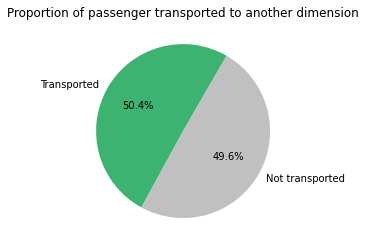

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(y_train.value_counts(), labels=["Transported", "Not transported"], 
       autopct='%1.1f%%', startangle=60, colors=['mediumseagreen', 'silver'])
plt.title("Proportion of passenger transported to another dimension")
plt.show()

**Classes are balanced - no need to use oversampling or undersampling.**

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6085 entries, 6926_01 to 8144_01
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    5936 non-null   object 
 1   CryoSleep     5937 non-null   object 
 2   Destination   5970 non-null   object 
 3   Age           5965 non-null   float64
 4   VIP           5958 non-null   object 
 5   RoomService   5959 non-null   float64
 6   FoodCourt     5954 non-null   float64
 7   ShoppingMall  5944 non-null   float64
 8   Spa           5961 non-null   float64
 9   VRDeck        5945 non-null   float64
 10  Travel_alone  6085 non-null   bool   
 11  Deck          5946 non-null   object 
 12  Cabin_num     5946 non-null   float64
 13  Side          5946 non-null   object 
dtypes: bool(1), float64(7), object(6)
memory usage: 671.5+ KB


### Features analysis

#### Numerical features

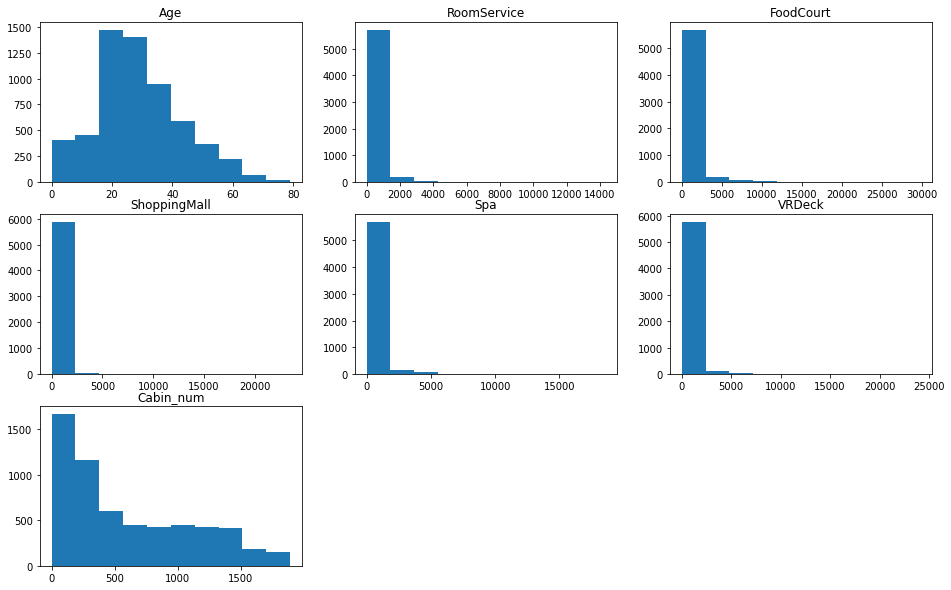

In [18]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.hist(X_train.Age)
plt.title("Age")
plt.subplot(332)
plt.hist(X_train.RoomService)
plt.title("RoomService")
plt.subplot(333)
plt.hist(X_train.FoodCourt)
plt.title("FoodCourt")
plt.subplot(334)
plt.hist(X_train.ShoppingMall)
plt.title("ShoppingMall")
plt.subplot(335)
plt.hist(X_train.Spa)
plt.title("Spa")
plt.subplot(336)
plt.hist(X_train.VRDeck)
plt.title("VRDeck")
plt.subplot(337)
plt.hist(X_train.Cabin_num)
plt.title("Cabin_num")

plt.show()

In [19]:
X_train.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num
count,5965.00,5959.00,5954.00,5944.00,5961.00,5945.00,5946.00
mean,28.82,224.49,469.73,180.44,315.77,298.64,598.66
std,14.48,654.59,1668.66,646.75,1167.27,1125.65,511.58
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00,166.00
50%,27.00,0.00,0.00,0.00,0.00,0.00,420.00
75%,37.00,56.50,82.00,30.00,58.00,47.00,1004.00
max,79.00,14327.00,29813.00,23492.00,18572.00,24133.00,1894.00


##### Age

- 125 records in 'Age' with value 0 - will be treated as children under 1 year of age and not treated as an mistake.
- 120 records NA (vs. 6085 all values) - will be replace by median

In [20]:
X_train.Age.min(), X_train.Age.max()

(0.0, 79.0)

In [21]:
X_train.loc[X_train['Age']<1, ['Age']].value_counts()

Age
0.0    125
dtype: int64

In [22]:
X_train.Age.isna().sum(), X_train.Age.shape[0]

(120, 6085)

##### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

Summary:
- Based on histograms and data description (above) and comparison (below), all of those features have the same structure: more than 50% of values are 0, 9-14% of values are rare (only single occurance). Therefore, the indicated features will be converted into categorical variables with three categories: 'zero', 'medium', 'rare'
- NA values will be added to 'zero' category (most frequent category)

In [23]:
print("\nComparison - percentage and quantity - 0 and rare values (single occurrence)")
table = {}
num_to_cat_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']  
rows = ['% of 0', 'amount of 0', '% of rare values','amount of rare values', "NA"]
for column in X_train[num_to_cat_features]:
    table.update({column: [X_train[column].value_counts(normalize=True)[0].round(2),
                          X_train[column].value_counts()[0],
                          ((X_train[column].value_counts() <= 1).sum() / X_train[column].count()).round(2),
                          (X_train[column].value_counts() <= 1).sum(),
                          X_train[column].isna().sum()
    ]})
pd.DataFrame(table, index=rows)


Comparison - percentage and quantity - 0 and rare values (single occurrence)


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
% of 0,0.65,0.64,0.65,0.63,0.64
amount of 0,3870.00,3788.00,3891.00,3737.00,3823.00
% of rare values,0.11,0.14,0.09,0.12,0.11
amount of rare values,669.00,854.00,561.00,702.00,671.00
NA,126.00,131.00,141.00,124.00,140.00


##### Cabin_num

- 139 NA records NA (vs. 6085 all values) - will be replace by median
- Some Cabins have the number "0" - recognize that this is not a mistake

In [24]:
X_train.Cabin_num.value_counts(dropna=False)

NaN       139
82.0       21
86.0       18
19.0       17
59.0       16
         ... 
1303.0      1
1853.0      1
824.0       1
764.0       1
1207.0      1
Name: Cabin_num, Length: 1691, dtype: int64

In [25]:
X_train.Cabin_num.isna().sum(), X_train.Cabin_num.shape[0]

(139, 6085)

In [26]:
X_train.loc[X_train['Cabin_num']==0, ['Side', 'Deck','Cabin_num']].value_counts()

Side  Deck  Cabin_num
S     E     0.0          3
P     A     0.0          1
      B     0.0          1
      C     0.0          1
      D     0.0          1
      F     0.0          1
      G     0.0          1
S     F     0.0          1
      G     0.0          1
dtype: int64

#### Categorical features

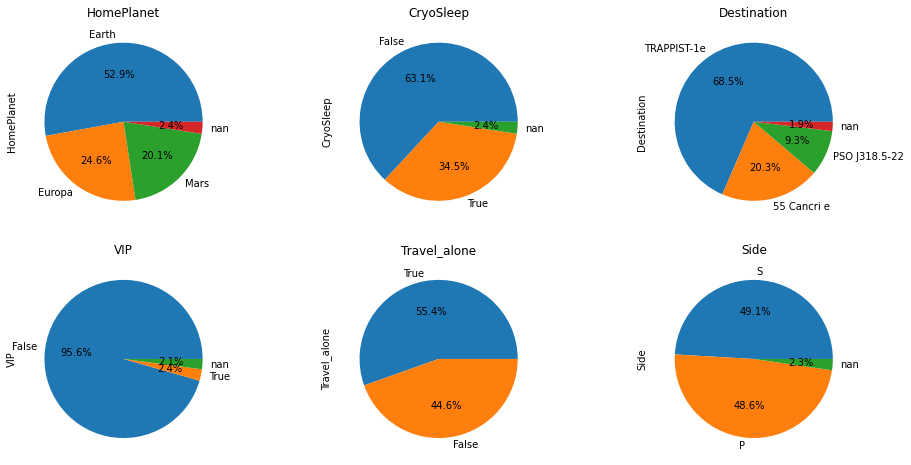

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(231)
X_train['HomePlanet'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("HomePlanet")
plt.subplot(232)
X_train['CryoSleep'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("CryoSleep")
plt.subplot(233)
X_train['Destination'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("Destination")
plt.subplot(234)
X_train['VIP'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("VIP")
plt.subplot(235)
X_train['Travel_alone'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("Travel_alone")
plt.subplot(236)
X_train['Side'].value_counts(dropna=False).plot(kind='pie', autopct='%1.1f%%', legend=False)
plt.title("Side")

plt.show()

##### HomePlanet, CryoSleep, Destination, VIP, Travel_alone, Side


- combine the NA values with the most common category
- feature "Travel_alone" has no NA values 

HomePlanet 

In [28]:
X_train.HomePlanet.value_counts(dropna=False)

Earth     3217
Europa    1494
Mars      1225
NaN        149
Name: HomePlanet, dtype: int64

CryoSleep

In [29]:
X_train.CryoSleep.value_counts(dropna=False)

False    3839
True     2098
NaN       148
Name: CryoSleep, dtype: int64

Destination

- the percentage comparison against the target does not give an unambiguous assignment for the NA value. Therefore, NaN values will be assigned to the most common category

In [30]:
X_train.Destination.value_counts(dropna=False)

TRAPPIST-1e      4168
55 Cancri e      1235
PSO J318.5-22     567
NaN               115
Name: Destination, dtype: int64

VIP


In [31]:
X_train.VIP.value_counts(dropna=False)

False    5815
True      143
NaN       127
Name: VIP, dtype: int64

Travel alone
- no NA values - feature derived from "PassengerId"

In [32]:
X_train.Travel_alone.value_counts(dropna=False)

True     3373
False    2712
Name: Travel_alone, dtype: int64

 Side

In [33]:
X_train.Side.value_counts(dropna=False)

S      2987
P      2959
NaN     139
Name: Side, dtype: int64

In [34]:
y_train.groupby(X_train.Side, dropna=False).mean()

Side
P      0.453870
S      0.556076
NaN    0.438849
dtype: float64

##### Deck

- 139 NA values
- Decks are not signed to side of the spaceship ("Side")

- The T deck with only 2 passengers assigned (capitan's cabin?) will also be assigned to the "infrequent" category
- 9 categories (with NA category). Some of the categories frequency are below 500  - aggregate smaller decks into one (OneHotEncoder, param: min_categoies = 500)
- The NA values will also be asigned as "infrequent" 

In [35]:
X_train.groupby(['Side', 'Deck']).size()

Side  Deck
P     A        77
      B       253
      C       227
      D       192
      E       302
      F       977
      G       929
      T         2
S     A        98
      B       304
      C       284
      D       154
      E       308
      F       947
      G       892
dtype: int64

In [36]:
X_train.Deck.value_counts(dropna=False)

F      1924
G      1821
E       610
B       557
C       511
D       346
A       175
NaN     139
T         2
Name: Deck, dtype: int64

In [37]:
X_train.Deck.value_counts(dropna=False, normalize=True)

F      0.316187
G      0.299260
E      0.100247
B      0.091537
C      0.083977
D      0.056861
A      0.028759
NaN    0.022843
T      0.000329
Name: Deck, dtype: float64

In [38]:
X_train.Deck.describe()

count     5946
unique       8
top          F
freq      1924
Name: Deck, dtype: object

In [39]:
y_train.groupby(X_train.Deck, dropna=False).mean()

Deck
A      0.502857
B      0.755835
C      0.669276
D      0.421965
E      0.370492
F      0.441268
G      0.511258
T      0.500000
NaN    0.438849
dtype: float64

## Feature preprocesing

- the remaining columns will be divided into groups depending on what functions will be performed on them
- separate classes have been created for numeric values that will be converted to categorical (with a large share of zero values)
- Using OneHotEncoder for rare categories, we assume that new categories will not appear

In [40]:
num_features = ['Age', 'Cabin_num']
narrow_cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side', 'Travel_alone']
multi_cat_features = ['Deck'] 
num_to_cat_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']  


multi_cat_frequency = 500

In [44]:
class RareAndNotRareAggregator(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=1, not_rare_raplace = 'medium', rare_replace ='rare'):
        self._validate_threshold(threshold)
        self.threshold = threshold
        self.rare_replace = rare_replace
        self.not_rare_raplace = not_rare_raplace
    
    def fit(self, X, y=None):
        self.most_frequent_val_ = {}
        self.most_frequent_val_with_zeros_ = {}
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        
        for col in X.columns:
            counts = X[col].value_counts()[1:]
            counts_with_zero = X[col].value_counts()
            self.most_frequent_val_[col] = set(counts.index[counts > self.threshold])
            self.most_frequent_val_with_zeros_[col] = set(counts_with_zero.index[counts_with_zero > self.threshold])
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X_copy = X.copy()
        n_samples, n_features = X_copy.shape

        for col in X_copy.columns:
                where_rare = ~X_copy[col].isin(self.most_frequent_val_with_zeros_[col])
                self._warn_if_only_rare(X, where_rare, col) 
                X_copy[col][where_rare] = self.rare_replace
                where_not_rare = X_copy[col].isin(self.most_frequent_val_[col])
                X_copy[col][where_not_rare] = self.not_rare_raplace

        if isinstance(X, np.ndarray):
            return X_copy.values
        else:
            return X_copy
        
    def _validate_threshold(self, threshold):
        if not isinstance(threshold, int):
            raise ValueError("Argument 'threshold' must be a intiger.")
        if threshold < 0:
            raise ValueError("Argument 'threshold' must be positive.")
    
    def _warn_if_only_rare(self, X, where_rare, col):
        if X.shape[0] > 1 and np.all(where_rare):
            warnings.warn(
                f"There were only rare values incolumns '{col}' - all values where replaced.")
            

In [45]:
class ZeroValuesAggregator(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold_for_zero=0.5, zero_replace='zero'):
        self.threshold_for_zero = threshold_for_zero
        self.zero_replace= zero_replace
        self._validate_threshold(threshold_for_zero)
        
           
    def fit(self, X, y=None):
        self.zero_values_ = {}
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)  
        for col in X.columns:
            if self.threshold_for_zero < X[col].value_counts(normalize=True)[0]:
                self.zero_values_[col] = [0,]
            else:
                raise ValueError(f"The occurrence of the value 0 in the column {col} is insufficient.")
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X_copy = X.copy()
        n_samples, n_features = X_copy.shape
        for col in X_copy.columns:
            where_zero = X_copy[col].isin(self.zero_values_[col])
            X_copy[col][where_zero] = self.zero_replace
        if isinstance(X, np.ndarray):
            return X_copy.values
        else:
            return X_copy
        
    def _validate_threshold(self, threshold_for_zero):
        if not isinstance(threshold_for_zero, float):
            raise ValueError("Argument 'threshold_for_zero' must be float")
        if threshold_for_zero < 0:
            raise ValueError("Argument 'threshold' must be positive.")
           

In [46]:
numerical_pipe = Pipeline([
    ("numerical_simple_imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

narrow_categorical_pipe = Pipeline([
    ("narrow_simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("narrow_one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

multi_categorical_pipe = Pipeline([
    ("multi_one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", 
                                      min_frequency=multi_cat_frequency, drop="first"))
])

num_to_cat_pipe = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("rare_val_aggregator", RareAndNotRareAggregator()),
    ("zero_value_aggregator", ZeroValuesAggregator()),
    ("num_to_cat_one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", drop='first'))
])

In [47]:
preprocessor = ColumnTransformer([
        ("numerical", numerical_pipe, num_features),
        ("narrow_categorical", narrow_categorical_pipe, narrow_cat_features),
        ("multi_categorical", multi_categorical_pipe, multi_cat_features),
        ("num_to_categorical", num_to_cat_pipe, num_to_cat_features)
    ], remainder="drop", n_jobs=-1
)

In [48]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=-1,
                  transformers=[('numerical',
                                 Pipeline(steps=[('numerical_simple_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Cabin_num']),
                                ('narrow_categorical',
                                 Pipeline(steps=[('narrow_simple_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('narrow_one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_un...
                                ('num_to_categorical',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('rare_val_aggregator',
                                                  RareAndNotRareAggregator()),
                                                 ('zero_value_aggregator',
                                                  ZeroValuesAggregator()),
                                                 ('num_to_cat_one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['RoomService', 'FoodCourt', 'ShoppingMall',
                                  'Spa', 'VRDeck'])])

In [49]:
preprocessor.transform(X_train)

array([[ 0.99139939,  1.65971638,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.22421304,  1.76635856,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.68246175, -0.82662637,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.75220596, -0.95894167,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.43344568,  1.10675691,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.13088782, -0.64098998,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

In [50]:
preprocessor.transform(X_train).shape

(6085, 25)

In [51]:
preprocessor.transformers

[('numerical',
  Pipeline(steps=[('numerical_simple_imputer', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler())]),
  ['Age', 'Cabin_num']),
 ('narrow_categorical',
  Pipeline(steps=[('narrow_simple_imputer',
                   SimpleImputer(strategy='most_frequent')),
                  ('narrow_one_hot_encoder',
                   OneHotEncoder(drop='first', handle_unknown='ignore'))]),
  ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side', 'Travel_alone']),
 ('multi_categorical',
  Pipeline(steps=[('multi_one_hot_encoder',
                   OneHotEncoder(drop='first',
                                 handle_unknown='infrequent_if_exist',
                                 min_frequency=500))]),
  ['Deck']),
 ('num_to_categorical',
  Pipeline(steps=[('simple_imputer',
                   SimpleImputer(fill_value=0, strategy='constant')),
                  ('rare_val_aggregator', RareAndNotRareAggregator()),
                  ('zero_value_aggregator', 

## Model 

### Logistic Regression

#### Base model

In [56]:
pipe_regr = Pipeline([
    ("preprocessor", preprocessor),
    ("model_regr", LogisticRegression())
])
pipe_regr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('rare_val_aggregator',
                                                                   RareAndNotRareAggregator()),
                                                                  ('zero_value_aggregator',
                                                                   ZeroValuesAggregator()),
                                                                  ('num_to_cat_one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck'])])),
                ('model_regr', LogisticRegression())])

In [57]:
y_pred_regr = pipe_regr.predict(X_test)
accuracy_regr = accuracy_score(y_test, y_pred_regr)
accuracy_regr_train = accuracy_score(y_train, pipe_regr.predict(X_train))
f1_regr = f1_score(y_test, y_pred_regr)
f1_regr_train = f1_score(y_train, pipe_regr.predict(X_train))
print('LogisticRegression')
print('Accuracy on test data: %0.3f' %accuracy_regr_train)
print('Accuracy on train data: %0.3f' %accuracy_regr)
print('f1 score on test data: %0.3f' %f1_regr_train)
print('f1 score on train data: %0.3f' %f1_regr)

LogisticRegression
Accuracy on test data: 0.761
Accuracy on train data: 0.769
f1 score on test data: 0.760
f1 score on train data: 0.769


#### Model with grid

In [58]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  


params ={"model_regr__C": uniform(loc=0.001, scale=10),
         "model_regr__penalty": ["l2"],
         'model_regr__tol': uniform(loc=0.000001, scale=0.001)}

optimizer_regr = RandomizedSearchCV(pipe_regr, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_regr.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck'])])),
                                             ('model_regr',
                                              LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model_regr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B62B3F40>,
                                        'model_regr__penalty': ['l2'],
                                        'model_regr__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B62B1160>},
                   scoring='accuracy', verbose=1)

In [59]:
y_pred_regr_cv = optimizer_regr.predict(X_test)
accuracy_regr_cv = accuracy_score(y_test, y_pred_regr_cv)
accuracy_regr_train_cv = accuracy_score(y_train, optimizer_regr.predict(X_train))

print('LogisticRegression')
print('Accuracy on test data: %0.3f' %accuracy_regr_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_regr_cv)
print(f'Best score: %0.3f' %optimizer_regr.best_score_)
print(f'Best params: {optimizer_regr.best_params_}')

LogisticRegression
Accuracy on test data: 0.761
Accuracy on train data: 0.769
Best score: 0.762
Best params: {'model_regr__C': 0.6070442797273191, 'model_regr__penalty': 'l2', 'model_regr__tol': 0.0008897743265209949}


### SVC

#### Base model

In [60]:
pipe_svc = Pipeline([
    ("preprocessor", preprocessor),
    ("model_SVC", SVC())
])
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('rare_val_aggregator',
                                                                   RareAndNotRareAggregator()),
                                                                  ('zero_value_aggregator',
                                                                   ZeroValuesAggregator()),
                                                                  ('num_to_cat_one_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck'])])),
                ('model_SVC', SVC())])

In [61]:
y_pred_svc = pipe_svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_svc_train = accuracy_score(y_train, pipe_svc.predict(X_train))
f1_svc = f1_score(y_test, y_pred_svc)
f1_svc_train = f1_score(y_train, pipe_svc.predict(X_train))
print('SVC - Support Vector Classification')
print('Accuracy on test data: %0.3f' %accuracy_svc_train)
print('Accuracy on train data: %0.3f' %accuracy_svc)
print('f1 score on test data: %0.3f' %f1_svc_train)
print('f1 score on train data: %0.3f' %f1_svc)

SVC - Support Vector Classification
Accuracy on test data: 0.784
Accuracy on train data: 0.773
f1 score on test data: 0.780
f1 score on train data: 0.769


#### Model with grid

Check kernel - linear or rbf.

In [62]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        "model_SVC__kernel": ["linear", "rbf"],
        "model_SVC__C": [0.01, 0.1, 1, 10]}

optimizer_svc = GridSearchCV(pipe_svc, params, 
                         scoring='accuracy',           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_svc.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('numerical_simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Cabin_num']),
                                                                        ('narrow_categorical',
                                                                         Pipeline(steps=[('narrow_si...
                                                                                         ('zero_value_aggregator',
                                                                                          ZeroValuesAggregator()),
                                                                                         ('num_to_cat_one_hot_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist'))]),
                                                                         ['RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck'])])),
                                       ('model_SVC', SVC())]),
             n_jobs=-1,
             param_grid={'model_SVC__C': [0.01, 0.1, 1, 10],
                         'model_SVC__kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [64]:
y_pred_svc_cv = optimizer_svc.predict(X_test)
accuracy_svc_cv = accuracy_score(y_test, y_pred_svc_cv)
accuracy_svc_train_cv = accuracy_score(y_train, optimizer_svc.predict(X_train))
print('SVC - Support Vector Classification - with grid')
print('Accuracy on test data: %0.3f' %accuracy_svc_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_svc_cv)
print(f'Best score: %0.3f' %optimizer_svc.best_score_)
print(f'Best params: {optimizer_svc.best_params_}')

SVC - Support Vector Classification - with grid
Accuracy on test data: 0.784
Accuracy on train data: 0.773
Best score: 0.764
Best params: {'model_SVC__C': 1, 'model_SVC__kernel': 'rbf'}


Optimization for the best kernel

In [66]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        "model_SVC__kernel": ["rbf"],
        "model_SVC__C": uniform(loc=0.001, scale=100),
        "model_SVC__gamma" : ["scale", "auto"]
}

optimizer_svc = RandomizedSearchCV(pipe_svc, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_svc.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='infrequent_if_exist'))]),
                                                                               ['RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck'])])),
                                             ('model_SVC', SVC())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model_SVC__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7AEA280>,
                                        'model_SVC__gamma': ['scale', 'auto'],
                                        'model_SVC__kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

In [67]:
y_pred_svc_cv = optimizer_svc.predict(X_test)
accuracy_svc_cv = accuracy_score(y_test, y_pred_svc_cv)
accuracy_svc_train_cv = accuracy_score(y_train, optimizer_svc.predict(X_train))
print('SVC - Support Vector Classification - with grid')
print('Accuracy on test data: %0.3f' %accuracy_svc_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_svc_cv)
print(f'Best score: %0.3f' %optimizer_svc.best_score_)
print(f'Best params: {optimizer_svc.best_params_}')

SVC - Support Vector Classification - with grid
Accuracy on test data: 0.811
Accuracy on train data: 0.776
Best score: 0.766
Best params: {'model_SVC__C': 4.0152136031348205, 'model_SVC__gamma': 'scale', 'model_SVC__kernel': 'rbf'}


### XGBoost

#### Base model

In [68]:
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model_xgb", XGBClassifier())
])
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [69]:
y_pred_xgb = pipe_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_xgb_train = accuracy_score(y_train, pipe_xgb.predict(X_train))
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_xgb_train = f1_score(y_train, pipe_xgb.predict(X_train))
print('XGBClasifier ')
print('Accuracy on test data: %0.3f' %accuracy_xgb_train)
print('Accuracy on train data: %0.3f' %accuracy_xgb)
print('f1 score on test data: %0.3f' %f1_xgb_train)
print('f1 score on train data: %0.3f' %f1_xgb)

XGBClasifier 
Accuracy on test data: 0.926
Accuracy on train data: 0.765
f1 score on test data: 0.925
f1 score on train data: 0.759


#### Model with grid

In [149]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        'model_xgb__n_estimators': [100, 150, 200, 250],
        'model_xgb__learning_rate': uniform(loc=0.1, scale=0.5),
        "model_xgb__gamma": uniform(loc=0.05, scale=3),
        "model_xgb__max_depth": [5, 6, 7],
        "model_xgb__min_child_weight": [10, 50, 70, 100],
        "model_xgb__subsample": [0.25, 0.5, 0.75, 1],
        "model_xgb__colsample_bynode": [0.1, 0.25, 0.5, 1]
}

optimizer_xgb = RandomizedSearchCV(pipe_xgb, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                        'model_xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7AAD9D0>,
                                        'model_xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7AAD460>,
                                        'model_xgb__max_depth': [5, 6, 7],
                                        'model_xgb__min_child_weight': [10, 50,
                                                                        70,
                                                                        100],
                                        'model_xgb__n_estimators': [100, 150,
                                                                    200, 250],
                                        'model_xgb__subsample': [0.25, 0.5,
                                                                 0.75, 1]},
                   scoring='accuracy', verbose=1)

In [151]:
y_pred_xgb_cv = optimizer_xgb.predict(X_test)
accuracy_xgb_cv = accuracy_score(y_test, y_pred_xgb_cv)
accuracy_xgb_train_cv = accuracy_score(y_train, optimizer_xgb.predict(X_train))
print('XGBClasifier - with grid')
print('Accuracy on test data: %0.3f' %accuracy_xgb_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_xgb_cv)
print(f'Best score: %0.3f' %optimizer_xgb.best_score_)
print(f'Best params: {optimizer_xgb.best_params_}')

XGBClasifier - with grid
Accuracy on test data: 0.764
Accuracy on train data: 0.770
Best score: 0.767
Best params: {'model_xgb__colsample_bynode': 1, 'model_xgb__gamma': 2.0747691055939543, 'model_xgb__learning_rate': 0.4343324225820958, 'model_xgb__max_depth': 6, 'model_xgb__min_child_weight': 50, 'model_xgb__n_estimators': 200, 'model_xgb__subsample': 0.5}


### Summary

- XGBoost has the best prediction result, comparable to SVC, but the SVC model took a long time to learn - possibly the amount of data is too big for this model
- Based on the results presented below, the XGBoost algorithm was selected - without optimization it is overfitting (prediction results on the training set are high and on the test set - much lower), but after using RandomizedSearchCV with a grid of selected hyperparameters, overfitting was abolished. 
- The 'accuracy' assessment method was chosen because the set is balanced. Comparison with the 'f1-score' method on base models gave similar results.

In [75]:
model_summary = pd.DataFrame({
    'Logistic Regression': [accuracy_regr_train, accuracy_regr, f1_regr_train, f1_regr, 
                            accuracy_regr_train_cv, accuracy_regr_cv, optimizer_regr.best_score_],
    'SVC': [accuracy_svc_train, accuracy_svc, f1_svc_train, f1_svc, 
            accuracy_svc_train_cv, accuracy_svc_cv, optimizer_svc.best_score_],
    'XGBoost': [accuracy_xgb_train, accuracy_xgb, f1_xgb_train, f1_xgb, 
                accuracy_xgb_train_cv, accuracy_xgb_cv, optimizer_xgb.best_score_]
}, 
    index=('accuracy_train', 'accuracy', 'f1_train', 'f1', 'accuracy_train_cv', 'accuracy_cv', 'optimizer_best_score'  ))
model_summary.round(3)

,Logistic Regression,SVC,XGBoost
accuracy_train,0.761,0.784,0.926
accuracy,0.769,0.773,0.765
f1_train,0.760,0.780,0.925
f1,0.769,0.769,0.759
accuracy_train_cv,0.761,0.811,0.774
accuracy_cv,0.769,0.776,0.776
optimizer_best_score,0.762,0.766,0.766


## Feature Selection

In [76]:
X_prep = preprocessor.fit_transform(X_train)

In [77]:
feature_name = list(pd.DataFrame(X_prep).columns)
n_features = 15

### Lasso: SelectFromModel

In [78]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="saga"), max_features=n_features)
embeded_lr_selector.fit(X_prep, y_train)

SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga'),
                max_features=15)

In [79]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = pd.DataFrame(X_prep).loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

15 selected features


### Random Forest: SelectFromModel

In [80]:
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=150), max_features=n_features)
rf_selector.fit(X_prep, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=150),
                max_features=15)

In [81]:
rf_support = rf_selector.get_support()
rf_feature = pd.DataFrame(X_prep).loc[:, rf_support].columns.tolist()
print(str(len(rf_feature)), 'selected features')

6 selected features


### SVC: SelectFromModel

In [82]:
embeded_svc_selector = SelectFromModel(SVC(kernel='linear'), max_features=n_features)
embeded_svc_selector.fit(X_prep, y_train) 

SelectFromModel(estimator=SVC(kernel='linear'), max_features=15)

In [83]:
svm_support = embeded_svc_selector.get_support()
svm_feature = pd.DataFrame(X_prep).loc[:,svm_support].columns.tolist()
print(str(len(svm_feature)), 'selected features')

11 selected features


### Logistic Regression: RFE 

In [87]:
rfe_selector = RFE(estimator=LogisticRegression(solver='saga'), n_features_to_select=n_features, step=1, verbose=5)
rfe_selector.fit(X_prep, y_train)

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


RFE(estimator=LogisticRegression(solver='saga'), n_features_to_select=15,
    verbose=5)

In [89]:
rfe_support = rfe_selector.get_support()
rfe_feature = pd.DataFrame(X_prep).loc[:, rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

15 selected features


### Summary of selectors

The selected and learned selectors have similar results - they unambiguously reject some features. Two were selected to be tested with the selected XGBoost model.

In [90]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature': feature_name, 'Logistics':embeded_lr_support,
                                    'Random Forest':rf_support, 'SVC':svm_support, 'RFE Logistics': rfe_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum((feature_selection_df.drop(['Feature'], axis=1)), axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(25)

,Feature,Logistics,Random Forest,SVC,RFE Logistics,Total
1,24,True,True,True,True,4
2,22,True,True,True,True,4
3,16,True,True,True,True,4
4,4,True,True,True,True,4
5,23,True,False,True,True,3
6,21,True,False,True,True,3
7,19,True,False,True,True,3
8,17,True,False,True,True,3
9,15,True,False,True,True,3
10,11,True,False,True,True,3


## Models with feature selection

### XGBoost with RFE

In [153]:
pipe_xgb_sel1 = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", RFE(estimator=LogisticRegression(solver='saga'), n_features_to_select=15, step=1)),
    ("model_xgb", XGBClassifier())
])
pipe_xgb_sel1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [154]:
y_pred_xgb_sel1 = pipe_xgb_sel1.predict(X_test)
accuracy_xgb_sel1 = accuracy_score(y_test, y_pred_xgb_sel1)
accuracy_xgb_sel1_train = accuracy_score(y_train, pipe_xgb_sel1.predict(X_train))
f1_xgb_sel1 = f1_score(y_test, y_pred_xgb_sel1)
f1_xgb_sel1_train = f1_score(y_train, pipe_xgb_sel1.predict(X_train))
print('XGBClasifier - selector1 ')
print('Accuracy on test data: %0.3f' %accuracy_xgb_sel1_train)
print('Accuracy on train data: %0.3f' %accuracy_xgb_sel1)
print('f1 score on test data: %0.3f' %f1_xgb_sel1_train)
print('f1 score on train data: %0.3f' %f1_xgb_sel1)

XGBClasifier - selector1 
Accuracy on test data: 0.787
Accuracy on train data: 0.764
f1 score on test data: 0.788
f1 score on train data: 0.770


In [155]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        'model_xgb__n_estimators': [100, 150, 200, 250],
        'model_xgb__learning_rate': uniform(loc=0.1, scale=0.5),
        "model_xgb__gamma": uniform(loc=0.05, scale=3),
        "model_xgb__max_depth": [5, 6, 7],
        "model_xgb__min_child_weight": [10, 50, 70, 100],
        "model_xgb__subsample": [0.25, 0.5, 0.75, 1],
        "model_xgb__colsample_bynode": [0.1, 0.25, 0.5, 1]
}

optimizer_xgb_sel1 = RandomizedSearchCV(pipe_xgb_sel1, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_xgb_sel1.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                        'model_xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B612DA60>,
                                        'model_xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B612D7F0>,
                                        'model_xgb__max_depth': [5, 6, 7],
                                        'model_xgb__min_child_weight': [10, 50,
                                                                        70,
                                                                        100],
                                        'model_xgb__n_estimators': [100, 150,
                                                                    200, 250],
                                        'model_xgb__subsample': [0.25, 0.5,
                                                                 0.75, 1]},
                   scoring='accuracy', verbose=1)

In [156]:
y_pred_xgb_sel1_cv = optimizer_xgb_sel1.predict(X_test)
accuracy_xgb_sel1_cv = accuracy_score(y_test, y_pred_xgb_sel1_cv)
accuracy_xgb_sel1_train_cv = accuracy_score(y_train, optimizer_xgb_sel1.predict(X_train))
print('XGBClasifier - with grid - selector1')
print('Accuracy on test data: %0.3f' %accuracy_xgb_sel1_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_xgb_sel1_cv)
print(f'Best score: %0.3f' %optimizer_xgb_sel1.best_score_)
print(f'Best params: {optimizer_xgb_sel1.best_params_}')

XGBClasifier - with grid - selector1
Accuracy on test data: 0.766
Accuracy on train data: 0.775
Best score: 0.766
Best params: {'model_xgb__colsample_bynode': 1, 'model_xgb__gamma': 1.570007854184319, 'model_xgb__learning_rate': 0.22036902973641678, 'model_xgb__max_depth': 7, 'model_xgb__min_child_weight': 50, 'model_xgb__n_estimators': 200, 'model_xgb__subsample': 0.5}


### XGBoost with Lasso SelectFromMode

In [157]:
pipe_xgb_sel2 = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SelectFromModel(LogisticRegression(penalty="l1", solver="saga"), max_features=n_features)),
    ("model_xgb", XGBClassifier())
])
pipe_xgb_sel2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [158]:
y_pred_xgb_sel2 = pipe_xgb_sel2.predict(X_test)
accuracy_xgb_sel2 = accuracy_score(y_test, y_pred_xgb_sel2)
accuracy_xgb_sel2_train = accuracy_score(y_train, pipe_xgb_sel2.predict(X_train))
f1_xgb_sel2 = f1_score(y_test, y_pred_xgb_sel2)
f1_xgb_sel2_train = f1_score(y_train, pipe_xgb_sel2.predict(X_train))
print('XGBClasifier - selector2 ')
print('Accuracy on test data: %0.3f' %accuracy_xgb_sel2_train)
print('Accuracy on train data: %0.3f' %accuracy_xgb_sel2)
print('f1 score on test data: %0.3f' %f1_xgb_sel2_train)
print('f1 score on train data: %0.3f' %f1_xgb_sel2)

XGBClasifier - selector2 
Accuracy on test data: 0.790
Accuracy on train data: 0.768
f1 score on test data: 0.790
f1 score on train data: 0.770


In [159]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        'model_xgb__n_estimators': [100, 150, 200, 250],
        'model_xgb__learning_rate': uniform(loc=0.1, scale=0.5),
        "model_xgb__gamma": uniform(loc=0.05, scale=3),
        "model_xgb__max_depth": [5, 6, 7],
        "model_xgb__min_child_weight": [10, 50, 70, 100],
        "model_xgb__subsample": [0.25, 0.5, 0.75, 1],
        "model_xgb__colsample_bynode": [0.1, 0.25, 0.5, 1]
}

optimizer_xgb_sel2 = RandomizedSearchCV(pipe_xgb_sel2, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_xgb_sel2.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                        'model_xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B3C22940>,
                                        'model_xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B3C22280>,
                                        'model_xgb__max_depth': [5, 6, 7],
                                        'model_xgb__min_child_weight': [10, 50,
                                                                        70,
                                                                        100],
                                        'model_xgb__n_estimators': [100, 150,
                                                                    200, 250],
                                        'model_xgb__subsample': [0.25, 0.5,
                                                                 0.75, 1]},
                   scoring='accuracy', verbose=1)

In [160]:
y_pred_xgb_sel2_cv = optimizer_xgb_sel2.predict(X_test)
accuracy_xgb_sel2_cv = accuracy_score(y_test, y_pred_xgb_sel2_cv)
accuracy_xgb_sel2_train_cv = accuracy_score(y_train, optimizer_xgb_sel2.predict(X_train))
print('XGBClasifier - with grid - selector2')
print('Accuracy on test data: %0.3f' %accuracy_xgb_sel2_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_xgb_sel2_cv)
print(f'Best score: %0.3f' %optimizer_xgb_sel2.best_score_)
print(f'Best params: {optimizer_xgb_sel2.best_params_}')

XGBClasifier - with grid - selector2
Accuracy on test data: 0.763
Accuracy on train data: 0.773
Best score: 0.766
Best params: {'model_xgb__colsample_bynode': 0.5, 'model_xgb__gamma': 0.17183837513640948, 'model_xgb__learning_rate': 0.26636177113568693, 'model_xgb__max_depth': 7, 'model_xgb__min_child_weight': 100, 'model_xgb__n_estimators': 150, 'model_xgb__subsample': 1}


## Summary

The best solution is presented by selector 1, i.e. a model using the RFE selector. This model will be used in the next steps.

In [161]:
sellector_summary = pd.DataFrame({
    "XGBoost with no selector": [accuracy_xgb_train_cv, accuracy_xgb_cv, optimizer_xgb.best_score_],
    "XGBoost with selector1": [accuracy_xgb_sel1_train_cv, accuracy_xgb_sel1_cv, optimizer_xgb_sel1.best_score_],
    "XGBoost with selector2": [accuracy_xgb_sel2_train_cv, accuracy_xgb_sel2_cv, optimizer_xgb_sel2.best_score_]
}, index=['accuracy_train', 'accuracy_test', 'optimizer_best_score'])
sellector_summary.round(3)

,XGBoost with no selector,XGBoost with selector1,XGBoost with selector2
accuracy_train,0.764,0.766,0.763
accuracy_test,0.770,0.775,0.773
optimizer_best_score,0.767,0.766,0.766


## PCA

In [117]:
preprocesor_pca = Pipeline([
    ("preprocessor", preprocessor),
    ("scaler_for_pca", StandardScaler())
])

X_train_for_pca = preprocessor.fit_transform(X_train)

In [118]:
pca = PCA()
pca.fit(X_train_for_pca)

PCA()

In [119]:
pca.components_.shape

(25, 25)

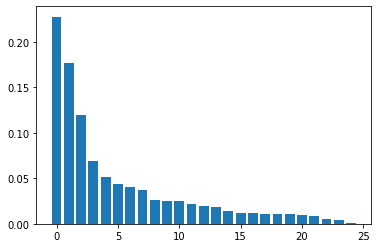

In [120]:
plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
plt.show()

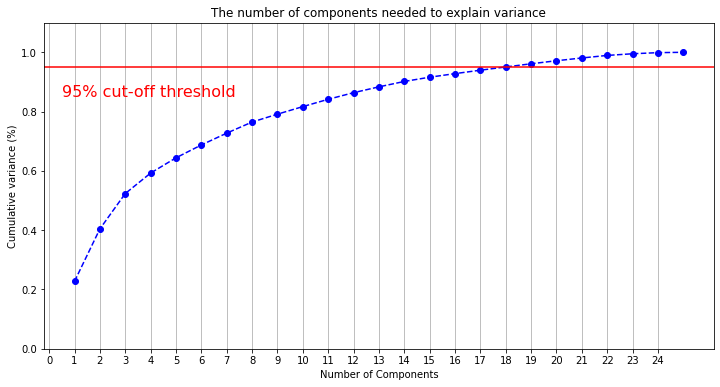

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 26, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 25, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

- As the graph for PCA shows, it is not possible to clearly indicate the value of n components for which there is a "break".
- The values of the n components 15 and 7 will be tested against the highest prediction score so far.

### XGBoost testing with PCA

In [163]:
pipe_xgb_sel1_pca = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", RFE(estimator=LogisticRegression(solver='saga'), n_features_to_select=15, step=1)),
    ("pca", PCA(15)),
    ("model_xgb", XGBClassifier())
])
pipe_xgb_sel1_pca.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [164]:
y_pred_xgb_sel1_pca = pipe_xgb_sel1_pca.predict(X_test)
accuracy_xgb_pca = accuracy_score(y_test, y_pred_xgb_sel1_pca)
accuracy_xgb_pca_train = accuracy_score(y_train, pipe_xgb_sel1_pca.predict(X_train))
print('XGBClasifier with PCA')
print('Accuracy on test data: %0.3f' %accuracy_xgb_pca_train)
print('Accuracy on train data: %0.3f' %accuracy_xgb_pca)

XGBClasifier with PCA
Accuracy on test data: 0.790
Accuracy on train data: 0.767


In [165]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        'model_xgb__n_estimators': [100, 150, 200, 250],
        'model_xgb__learning_rate': uniform(loc=0.1, scale=0.5),
        "model_xgb__gamma": uniform(loc=0.05, scale=3),
        "model_xgb__max_depth": [5, 6, 7],
        "model_xgb__min_child_weight": [10, 50, 70, 100],
        "model_xgb__subsample": [0.25, 0.5, 0.75, 1],
        "model_xgb__colsample_bynode": [0.1, 0.25, 0.5, 1]
}


optimizer_xgb_sel1_pca = RandomizedSearchCV(pipe_xgb_sel1_pca, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_xgb_sel1_pca.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                        'model_xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B62B3F70>,
                                        'model_xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7AFF9A0>,
                                        'model_xgb__max_depth': [5, 6, 7],
                                        'model_xgb__min_child_weight': [10, 50,
                                                                        70,
                                                                        100],
                                        'model_xgb__n_estimators': [100, 150,
                                                                    200, 250],
                                        'model_xgb__subsample': [0.25, 0.5,
                                                                 0.75, 1]},
                   scoring='accuracy', verbose=1)

In [166]:
y_pred_xgb_sel1_pca_cv = optimizer_xgb_sel1_pca.predict(X_test)
accuracy_xgb_pca_cv = accuracy_score(y_test, y_pred_xgb_sel1_pca_cv)
accuracy_xgb_pca_train_cv = accuracy_score(y_train, optimizer_xgb_sel1_pca.predict(X_train))
print('XGBClasifier - with grid - PCA')
print('Accuracy on test data: %0.3f' %accuracy_xgb_pca_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_xgb_pca_cv)
print(f'Best score: %0.3f' %optimizer_xgb_pca.best_score_)
print(f'Best params: {optimizer_xgb_pca.best_params_}')

XGBClasifier - with grid - PCA
Accuracy on test data: 0.775
Accuracy on train data: 0.777
Best score: 0.759
Best params: {'model_xgb__colsample_bynode': 0.1, 'model_xgb__gamma': 0.7925523530077209, 'model_xgb__learning_rate': 0.2617549359089971, 'model_xgb__max_depth': 5, 'model_xgb__min_child_weight': 70, 'model_xgb__n_estimators': 100, 'model_xgb__subsample': 0.75}


In [168]:
pipe_xgb_sel1_pca2 = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(7)),
    ("model_xgb", XGBClassifier())
])

kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

params = {
        'model_xgb__n_estimators': [100, 150, 200, 250],
        'model_xgb__learning_rate': uniform(loc=0.1, scale=0.5),
        "model_xgb__gamma": uniform(loc=0.05, scale=3),
        "model_xgb__max_depth": [5, 6, 7],
        "model_xgb__min_child_weight": [10, 50, 70, 100],
        "model_xgb__subsample": [0.25, 0.5, 0.75, 1],
        "model_xgb__colsample_bynode": [0.1, 0.25, 0.5, 1]
}


optimizer_xgb_sel1_pca2 = RandomizedSearchCV(pipe_xgb_sel1_pca2, params, 
                         scoring='accuracy',
                         n_iter=100,           
                         cv=kfold, 
                         verbose=1,
                         n_jobs=-1) 

optimizer_xgb_sel1_pca2.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('numerical',
                                                                               Pipeline(steps=[('numerical_simple_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Cabin_num']),
                                                                              ('narrow_categorical',
                                                                               Pipeline(steps=[('nar...
                                        'model_xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7C8E160>,
                                        'model_xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002C0B7AA4040>,
                                        'model_xgb__max_depth': [5, 6, 7],
                                        'model_xgb__min_child_weight': [10, 50,
                                                                        70,
                                                                        100],
                                        'model_xgb__n_estimators': [100, 150,
                                                                    200, 250],
                                        'model_xgb__subsample': [0.25, 0.5,
                                                                 0.75, 1]},
                   scoring='accuracy', verbose=1)

In [169]:
y_pred_xgb_sel1_pca2_cv = optimizer_xgb_sel1_pca2.predict(X_test)
accuracy_xgb_pca2_cv = accuracy_score(y_test, y_pred_xgb_sel1_pca2_cv)
accuracy_xgb_pca2_train_cv = accuracy_score(y_train, optimizer_xgb_sel1_pca2.predict(X_train))
print('XGBClasifier - with grid - PCA2')
print('Accuracy on test data: %0.3f' %accuracy_xgb_pca2_train_cv)
print('Accuracy on train data: %0.3f' %accuracy_xgb_pca2_cv)
print(f'Best score: %0.3f' %optimizer_xgb_pca2.best_score_)
print(f'Best params: {optimizer_xgb_pca2.best_params_}')

XGBClasifier - with grid - PCA2
Accuracy on test data: 0.794
Accuracy on train data: 0.747


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

### Summary of PCA

- Reducing dimensions using PCA brings good results for n components = 15. This solution will be accepted as the best one.
- For n components = 7 there is considerable overfitting.

In [170]:
PCA_summary = pd.DataFrame({
    "XGBoost with no PCA": [accuracy_xgb_train_cv, accuracy_xgb_cv, optimizer_xgb_sel1.best_score_],
    "XGBoost with PCA(15)": [accuracy_xgb_pca_train_cv, accuracy_xgb_pca_cv, optimizer_xgb_sel1_pca.best_score_],
    "XGBoost with PCA(7)": [accuracy_xgb_pca2_train_cv, accuracy_xgb_pca2_cv, optimizer_xgb_sel1_pca2.best_score_],
}, index=['accuracy_train', 'accuracy_test', 'optimizer_best_score'])
PCA_summary.round(3)

,XGBoost with no PCA,XGBoost with PCA(15),XGBoost with PCA(7)
accuracy_train,0.764,0.775,0.794
accuracy_test,0.770,0.777,0.747
optimizer_best_score,0.766,0.761,0.737


## Cross-validation of the best model

In [199]:
vizual_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(2))
])
X_pca = vizual_pipe.fit_transform(X, y)

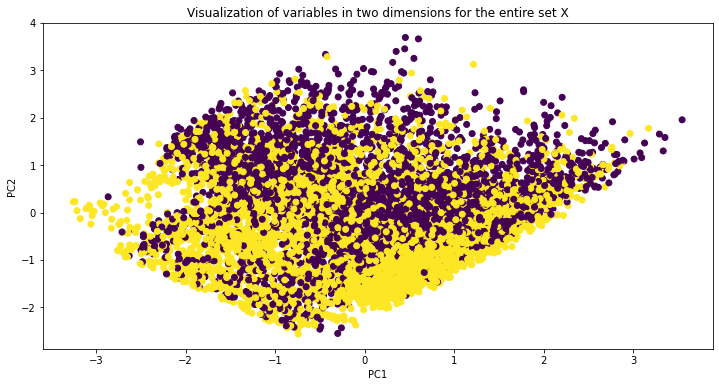

In [201]:
plt.scatter(X_pca[:,0], X_pca[:,1], c = y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualization of variables in two dimensions for the entire set X")
plt.show()

In [177]:
optimizer_xgb_sel1_pca.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('numerical_simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Cabin_num']),
                                                 ('narrow_categorical',
                                                  Pipeline(steps=[('narrow_simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('narrow_one_hot_encoder',
                                                                   OneH...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.17073013819850189, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=70,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [216]:
confusion_matrix(y_test, y_pred_xgb_sel1_pca_cv)

array([[1021,  274],
       [ 307, 1006]], dtype=int64)

In [194]:
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  

final_model = cross_val_score(optimizer_xgb_sel1_pca.best_estimator_, X, y, cv=kfold)

In [195]:
final_model

array([0.76896552, 0.76321839, 0.75747126, 0.76524741, 0.76179517,
       0.77100115, 0.77790564, 0.7698504 , 0.76179517, 0.75834292])

In [214]:
print("Cross-validation mean result for the entire set")
final_model.mean()

Cross-validation mean result for the entire set


0.7655593032022538

## Summary and recommendations

The average cross-validation result for the best model is not very high (0.766), there is potential for further optimization - selecting a different type of data selection, for manipulating PCA vectors - selected variants were tested in this project due to the high computational cost. Also, the potential for optimization lies in the data itself - not all possible features transformation options have been used. Some issues can be treated in a different way - for example: data for children under the age of one who travel alone can be treated as an error. I consider the final result as good; also the confusion matrix shows that the model confuses evenly.